# Basic tour through turbESN
This should be understood as a first simple introduction to the turbESN package. 

It covers a closed loop prediction of the Lorenz '63 system.

In [1]:
import torch
import numpy as np
import h5py                      
import matplotlib.pyplot as plt

import turbESN
from turbESN.core import ESN
from turbESN.util import minmax_scaling, PreparePredictorData,RunturbESN

### 1. Import Lorenz '63 Data
- the L63 system has three degrees of freedom: X, Y, Z
- the generated data consists out of 5000 timesteps

Text(0.5, 0, 'time step')

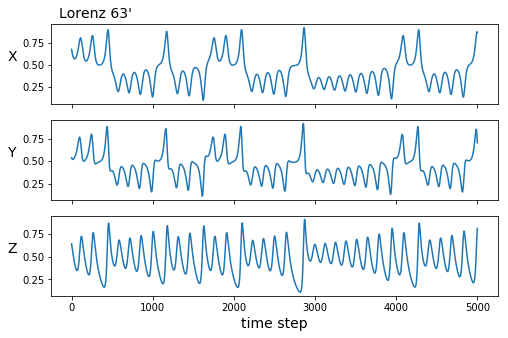

In [2]:
data = np.load('Lorenz63.npy')
data_timesteps, n_input_data= data.shape

# Visualize data
ylabels = ['X','Y','Z']
fig,axs = plt.subplots(figsize = (8,5), nrows = 3, sharex = True)
for ii in range(n_input_data):
    axs[ii].plot(data[:,ii])  
    axs[ii].set_ylabel(ylabels[ii], fontsize = 14, rotation = 0, labelpad = 10)
axs[0].set_title("Lorenz 63'", x = .1, fontsize = 14)
axs[-1].set_xlabel('time step',fontsize = 14)

### 2. Prepare Data for ESN
Let's prepare the imported temporal data for input of the ESN:
- define no. time steps in training/testing/validation phase
- scale data to values in [-1,1]

In [3]:
# Data parameters
trainingLength = 2050       # length of training phase
testingLength = 1000        # length of testing phase
validationLength = 1000     # length of validation phase
transientTime = 50          # initial transient that will be discarded from training (used for reservoir initialization)
esn_start = 1               # time step of data at which training phase should start
esn_end = esn_start + trainingLength + testingLength + validationLength    # time step of data at which validation phase should stop

# Min-Max normalization. Note: normalization over training phase only.
x_min = np.min(data[:trainingLength],axis=0)
x_max = np.max(data[:trainingLength],axis=0)
data_scaled = minmax_scaling(data,x_min=x_min,x_max=x_max,dataScaling=1)

# Create training/testing/validation data using PreparePredictorData method
u_train, y_train, u_test, y_test, u_val, y_val = PreparePredictorData(data=data_scaled, 
                                                                      n_input=n_input_data, 
                                                                      trainingLength=trainingLength, 
                                                                      testingLength=testingLength, 
                                                                      validationLength=validationLength,
                                                                      esn_start=esn_start,
                                                                      esn_end=esn_end)

### 3. Initialize ESN :
Create ESN object, where all information on ESN instance is stored.

By default the ESN will be used in closed loop mode (autonomous prediction, where the last prediction is used as next ESN input)

In [4]:
# Hyperparameters
randomSeed = 41 
n_reservoir = 256
leakingRate = 0.1
spectralRadius =  1.1
reservoirDensity = 0.2
regressionParameter = 5e-1

#ESN
esn = ESN(randomSeed=randomSeed,
           esn_start=esn_start,
           esn_end=esn_end,
           trainingLength=trainingLength,
           testingLength=testingLength,
           validationLength=validationLength,
           data_timesteps=data_timesteps,
           n_input=n_input_data,
           n_output=n_input_data,
           n_reservoir=n_reservoir,
           leakingRate=leakingRate,
           spectralRadius=spectralRadius,
           reservoirDensity=reservoirDensity,
           regressionParameter=regressionParameter)

### Run ESN 
RunturbESN:
- simple method that takes the **ESN object**, **training/validation/testing data** as input
- it returns the **predictions** of validation & testing phase, as well as the **MSE** for each time step of all three phases

In [7]:
mse_train, mse_test, mse_val, y_pred_test, y_pred_val = RunturbESN(esn=esn, 
                                                                   u_train=u_train, 
                                                                   y_train=y_train, 
                                                                   y_test=y_test, 
                                                                   u_test=u_test, 
                                                                   u_val=u_val,
                                                                   y_val=y_val)

print("MSE (train) = {0:.2e}\n".format(mse_train.mean()) + "MSE (test) = {0:.2e}\n".format(mse_test.mean()) + "MSE (val) = {0:.2e}\n".format(mse_val.mean()))

MSE (train) = 6.67e-06
MSE (test) = 1.43e-01
MSE (val) = 4.47e-01



### Evaluate Result

Lets compare the time trajectories of both prediction and ground truth during the testing phase.

Text(0.5, 0, 'time step')

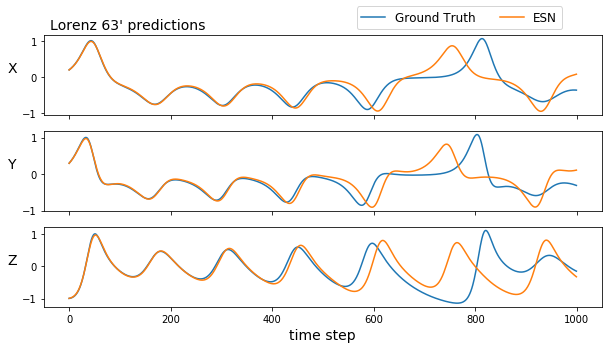

In [12]:
import seaborn as sns
ylabels = ['X','Y','Z']
clrs = sns.color_palette()
fig,axs = plt.subplots(figsize = (10,5), nrows = 3, sharex = True)
for ii in range(n_input_data):
    axs[ii].plot(range(testingLength),y_test[:,ii], label = 'Ground Truth',color = clrs[0])
    axs[ii].plot(range(testingLength),y_pred_test[:,ii], label = 'ESN',color=clrs[1])
    axs[ii].set_ylabel(ylabels[ii], fontsize = 14, rotation = 0, labelpad = 10)
    #axs[ii].grid()
    
axs[0].legend(fontsize = 12, ncol = 3, loc = 'lower left', bbox_to_anchor = (.55,1))
axs[0].set_title("Lorenz 63' predictions", x = .15, fontsize = 14)
axs[-1].set_xlabel('time step',fontsize = 14)

We can also reconstruct the chaotic attractor given by the Z-X plane.

Text(0, 0.5, 'Z')

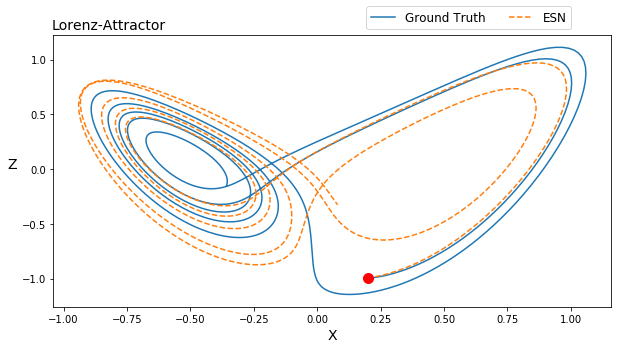

In [15]:
fig,axs = plt.subplots(figsize = (10,5))
axs.plot(y_test[:,0],y_test[:,2],label = 'Ground Truth')
axs.plot(y_pred_test[:,0],y_pred_test[:,2],label = 'ESN', linestyle = 'dashed')
axs.plot(y_test[0,0],y_test[0,2],color="red",marker=".",markersize=20)
axs.legend(fontsize = 12, ncol = 2, loc = 'lower left', bbox_to_anchor = (.55,1))
axs.set_title("Lorenz-Attractor", x = .1, fontsize = 14)
axs.set_xlabel("X", fontsize = 14, rotation = 0)
axs.set_ylabel("Z", fontsize = 14, rotation = 0, labelpad = 10)
